# ACCESS-OM3 and ACCESS-OM2 timeseries
Includes both scalar variables and spatial averages of 2d variables.

In [1]:
%matplotlib inline
import pandas as pd
import intake
import xarray as xr
import numpy as np
import cf_xarray as cfxr
import pint_xarray
from pint import application_registry as ureg
import cf_xarray.units
import cftime
import xgcm
import os

import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft

from dask.distributed import Client

In [2]:
xr.set_options(keep_attrs=True); # cf_xarray works best when xarray keeps attributes by default

In [3]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42399,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45687,Total threads: 1
Dashboard: /proxy/40123/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:43817,


In [4]:
thisdir = './'

### Define data sources

https://access-nri.zulipchat.com/#narrow/dm/784080,784272-dm/near/529767260
```
/g/data/tm70/ml0072/COMMON/git_repos/candelete/choice2
/g/data/tm70/ml0072/COMMON/git_repos/candelete/choice2_only_neutral_diffusion
/g/data/tm70/ds0092/model/config/om3_MC_25km_jra_ryf_631+634+235
```
These are the three runs related to https://github.com/ACCESS-NRI/access-om3-configs/issues/647#issuecomment-3086863360
`choice2` does not use density coords but is otherwise and identical config to the beta release.

------------------------------

```
/g/data/tm70/ml0072/COMMON/git_repos/candelete/test_current_config_0.0_w_rho_coord_with_GM_RR
```
is the "formal" beta release run with all settings exactly as on github. It has currently finished 7 years. I plan to continue running it throughout the week and aim to reach 20 years by the end of the week.


In [5]:
catalogs = [
                # # '/g/data/tm70/ds0092/model/config/om3_MC_25km_jra_ryf_631+634+235/archive/experiment_datastore.json',
                # # '/g/data/tm70/ml0072/COMMON/git_repos/candelete/choice2_only_neutral_diffusion/archive/experiment_datastore.json',
                # # '/g/data/tm70/ml0072/COMMON/git_repos/candelete/choice2/archive/experiment_datastore.json',
                # # '/g/data/tm70/ml0072/COMMON/git_repos/candelete/test_current_config_0.0_w_rho_coord_with_GM_RR/archive/experiment_datastore.json',
                # '/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json',
                '/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json',
            ]
catalogs

['/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json']

In [6]:
datastores = { os.path.normpath(c).split(os.sep)[-2]: intake.open_esm_datastore(c, columns_with_iterables=['variable']) for c in catalogs }
datastores

{'25km-iaf-test-for-AK-expt-7df5ef4c': <datastore catalog with 17 dataset(s) from 6432 asset(s)>}

In [7]:
# ACCESS-OM2-025 experiment
# use control - see https://forum.access-hive.org.au/t/access-om2-control-experiments/258
# om2expt = '025deg_jra55_ryf9091_gadi'
om2expt = '025deg_jra55_iaf_omip2_cycle1'
om2cat = intake.cat.access_nri[om2expt]

### Load grid data
This is needed for xgcm so we can get spatial averages of non-scalar data.

In [8]:
# get coords from short run without processor masking
# https://github.com/aekiss/MOM6-CICE6/commit/59ed8ffc6ae1d4a79821a951924e7c853d9b788a
# https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html#A-note-on-geographical-coordinates
static = xr.open_dataset('/g/data/ik11/outputs/access-om3-025/grid/access-om3.mom6.static.nc')

see https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html#xgcm-grid-definition

ACCESS-OM3 uses a non-symmetric memory layout, i.e. all fields have the same i and j sizes. See
https://mom6.readthedocs.io/en/main/api/generated/pages/Horizontal_Indexing.html?highlight=symmetric#declaration-of-variables

`MOM_parameter_doc.layout`:
```
!SYMMETRIC_MEMORY_ = False      !   [Boolean]
                                ! If defined, the velocity point data domain includes every face of the
                                ! thickness points. In other words, some arrays are larger than others,
                                ! depending on where they are on the staggered grid.  Also, the starting index
                                ! of the velocity-point arrays is usually 0, not 1. This can only be set at
                                ! compile time.```


In [9]:
# for non-symmetric 
# SYMMETRIC_MEMORY_ = False
# see https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html#xgcm-grid-definition
# and https://xgcm.readthedocs.io/en/latest/grid_metrics.html#Using-metrics-with-xgcm
grid = xgcm.Grid(static,
                 coords={'X': {'center': 'xh', 'right': 'xq'},
                         'Y': {'center': 'yh', 'right': 'yq'},},
                         # 'Z': { 'inner': 'zl', 'outer': 'zi'}},
                 metrics = {
                        ('X',): ['dxt', 'dxCu', 'dxCv'], # X distances
                        ('Y',): ['dyt', 'dyCu', 'dyCv'], # Y distances
                        ('X', 'Y'): ['areacello', 'areacello_cu', 'areacello_cv', 'areacello_bu'] # Areas
                        },
                 periodic=['X'])

### Define list of variables and load them

In [10]:
fields = { # key is OM3 name, value is OM2 name
    # 'mlotst': 'mld',
    # keys from ncdump -h ctrl_run_25km_0.5/archive/output009/access-om3.mom6.scalar.1day.snap.1962.nc | grep double
    'soga': 'salt_global_ave',
    'thetaoga': 'temp_global_ave',
    'tosga': 'temp_surface_ave',
    'sosga': 'salt_surface_ave',
    'speed_max': None,
    'mlotst_max': None,
    'tos_max': None,
    'tos_min': None,
    'sos_max': None,
    'sos_min': None,
    'zos_max': None,
    'zos_min': None, 
    # 'total_salt_Flux_Added': None,
    # 'total_salt_Flux_In': None,
    # 'total_salt_flux': None,
    # 'net_fresh_water_global_adjustment': None,
    # 'salt_flux_global_restoring_adjustment': None,
    # 'total_wfo': None,
    # 'total_evs': None,
    # 'total_fsitherm': None,
    # 'total_precip': None,
    # 'total_prsn': None,
    # 'total_lprec': None,
    # 'total_ficeberg': None,
    # 'total_friver': None,
    # 'total_net_massout': None,
    # 'total_net_massin': None,
}
fields

{'soga': 'salt_global_ave',
 'thetaoga': 'temp_global_ave',
 'tosga': 'temp_surface_ave',
 'sosga': 'salt_surface_ave',
 'speed_max': None,
 'mlotst_max': None,
 'tos_max': None,
 'tos_min': None,
 'sos_max': None,
 'sos_min': None,
 'zos_max': None,
 'zos_min': None}

In [11]:
# from https://github.com/COSIMA/cosima-recipes/blob/main/Cooking-Lessons-101-Tutorials/ACCESS-NRI_Intake_Catalog.ipynb
# Speeding up opening your datasets
# Try passing the following argument to your to_dask or to_dataset_dict call:
# See the xarray documentation on Reading multi-file datasets for more details about these arguments.
# https://docs.xarray.dev/en/stable/user-guide/io.html#reading-multi-file-datasets

xarray_combine_by_coords_kwargs=dict(
    compat="override",
    data_vars="minimal",
    coords="minimal"
)

In [12]:
# load data, with lots of workarounds for disambiguation
data = dict()
for k, om2 in fields.items():
    print(k)
    # d = [ ds.search(variable=k).to_dataset_dict(xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs) for ds in datastores ]
    try:
        d = { n: ds.search(variable=k) for n, ds in datastores.items() }
        d = { n: ds.to_dask(xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs) for n, ds in d.items() if ds } # avoid .to_dask() for empty datasets
    except ValueError:
        try:
            d = { n: ds.search(variable=k, frequency='1mon', variable_cell_methods='.*time: mean.*') for n, ds in datastores.items() }
            d = { n: ds.to_dask(xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs) for n, ds in d.items() if ds } # avoid .to_dask() for empty datasets
        except:
            try:
                d = { n: ds.search(variable=k, variable_cell_methods='.*time: mean.*') for n, ds in datastores.items() }
                d = { n: ds.to_dask(xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs) for n, ds in d.items() if ds } # avoid .to_dask() for empty datasets
            except:
                try:
                    d = { n: ds.search(variable=k, variable_cell_methods='.*time: point.*') for n, ds in datastores.items() }
                    d = { n: ds.to_dask(xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs) for n, ds in d.items() if ds } # avoid .to_dask() for empty datasets
                except:
                    try:
                        d = { n: ds.search(variable=k, variable_cell_methods='.*time: min.*') for n, ds in datastores.items() }
                        d = { n: ds.to_dask(xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs) for n, ds in d.items() if ds } # avoid .to_dask() for empty datasets
                    except:
                        try:
                            d = { n: ds.search(variable=k, variable_cell_methods='.*time: max.*') for n, ds in datastores.items() }
                            d = { n: ds.to_dask(xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs) for n, ds in d.items() if ds } # avoid .to_dask() for empty datasets
                        except:
                            print(f'{k} failed')
                            continue
    if om2 is None: # add access-om2 data,with variable name changed to match om3
        d2 = {}
    else:
        # d[om2expt] = om2cat.search(variable=om2).to_dask().rename({om2: k})
        d2 = {om2expt: om2cat.search(variable=om2, frequency=d[list(d.keys())[0]].attrs['intake_esm_attrs:frequency']).to_dask().rename({om2: k})}
    # if d:
    #     data[k] = xr.concat(d, 'time')
    # else:
    #     print(f'no data for {k}')
    # break
    data[k] = d2 | d
    # break
data

soga


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


thetaoga


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


tosga


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


sosga


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


speed_max


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


mlotst_max


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


tos_max


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


tos_min


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


sos_max


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


sos_min


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


zos_max


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


zos_min


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


{'soga': {'025deg_jra55_iaf_omip2_cycle1': <xarray.Dataset> Size: 356kB
  Dimensions:      (time: 22280, scalar_axis: 1)
  Coordinates:
    * scalar_axis  (scalar_axis) float64 8B 0.0
    * time         (time) datetime64[ns] 178kB 1957-12-31 ... 2018-12-30
  Data variables:
      soga         (time, scalar_axis) float64 178kB dask.array<chunksize=(1, 1), meta=np.ndarray>
  Attributes: (12/16)
      filename:                                 ocean_scalar_snapshot.nc
      title:                                    ACCESS-OM2
      grid_type:                                mosaic
      grid_tile:                                1
      intake_esm_vars:                          ['salt_global_ave']
      intake_esm_attrs:filename:                ocean_scalar_snapshot.nc
      ...                                       ...
      intake_esm_attrs:variable_standard_name:  ,,,,sea_water_salinity,,,sea_wa...
      intake_esm_attrs:variable_cell_methods:   time: point,time: point,time: p...
      in

In [13]:
data.keys()

dict_keys(['soga', 'thetaoga', 'tosga', 'sosga', 'speed_max', 'mlotst_max', 'tos_max', 'tos_min', 'sos_max', 'sos_min', 'zos_max', 'zos_min'])

### Plot timeseries

In [14]:
# set date range
# trange = slice(cftime.DatetimeNoLeap(1900, 1, 1, 0, 0, 0, 0),
#                cftime.DatetimeNoLeap(1960, 1, 1, 0, 0, 0, 0))
trange = slice(None, None)

soga
thetaoga
tosga
sosga
speed_max
mlotst_max
tos_max
tos_min
sos_max
sos_min
zos_max
zos_min


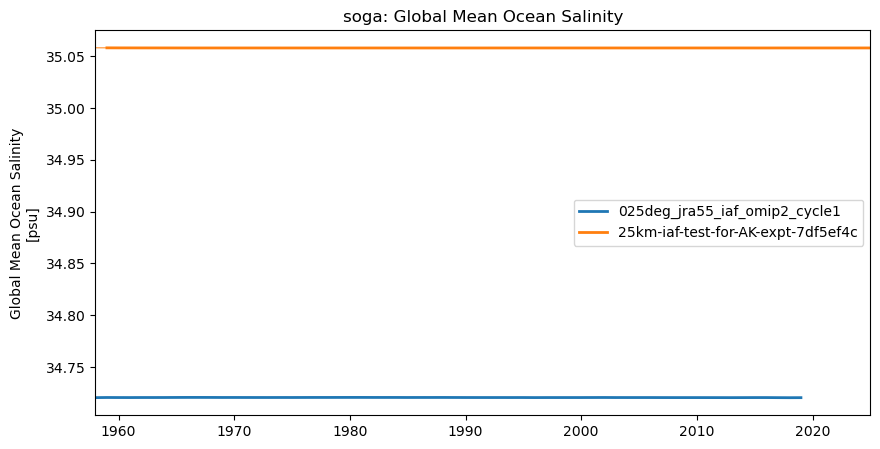

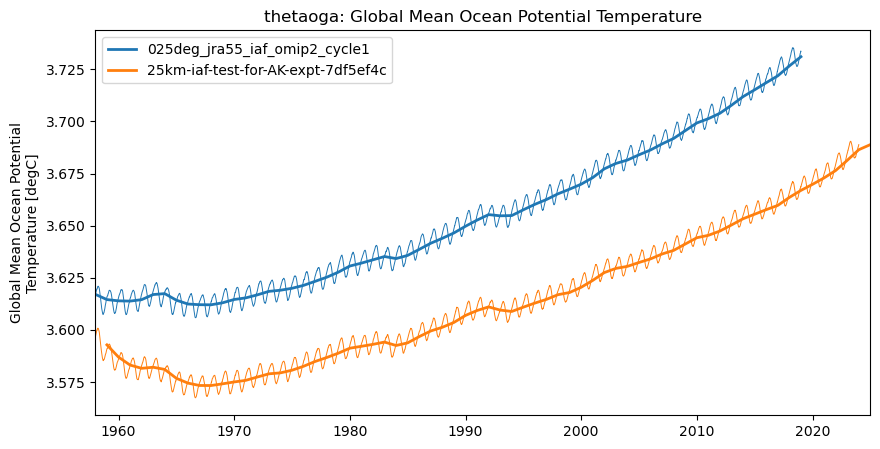

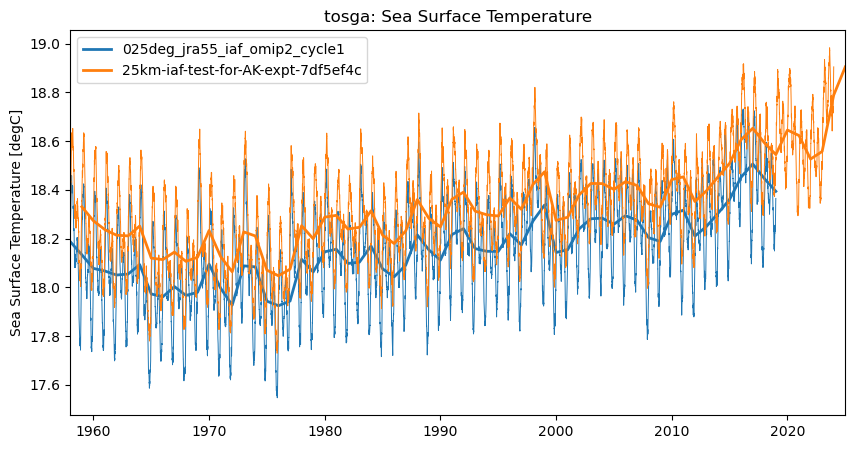

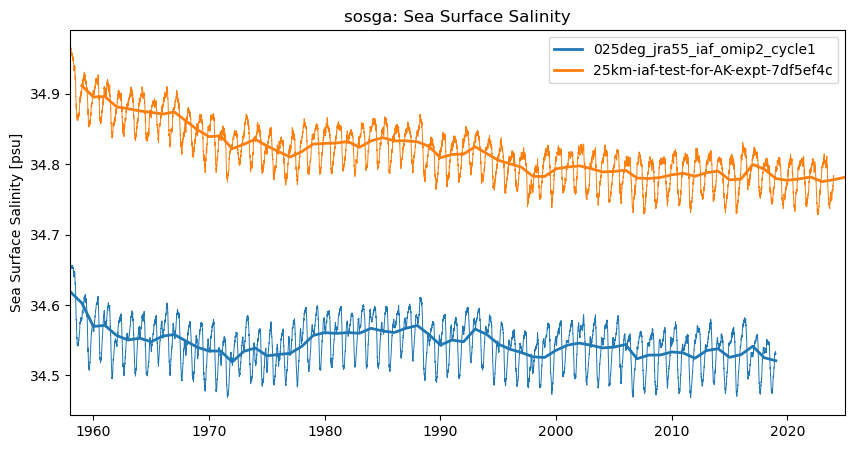

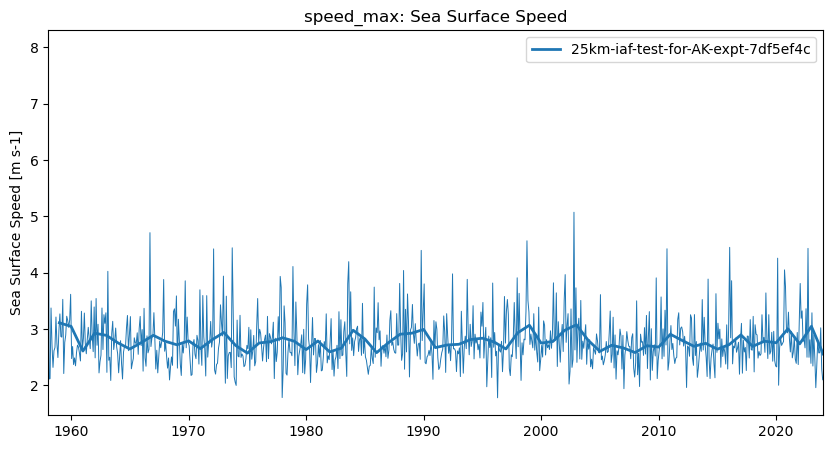

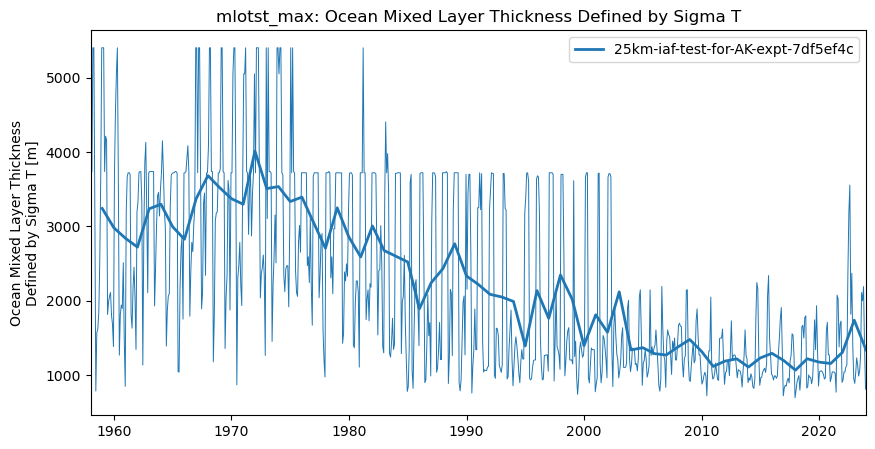

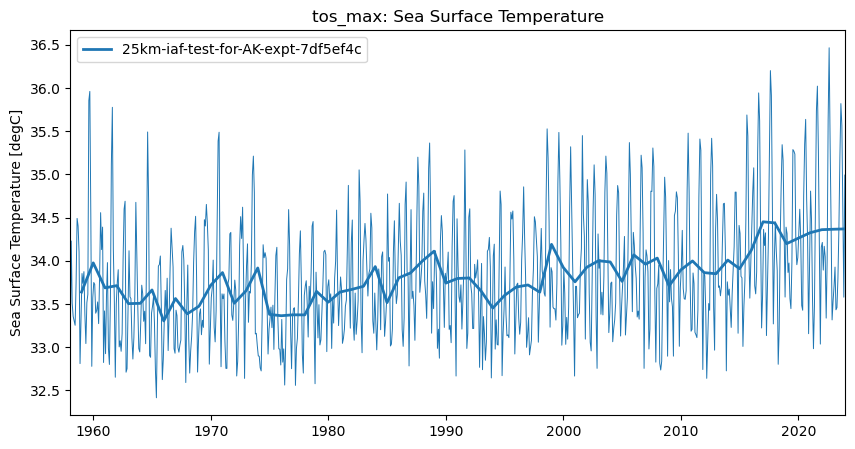

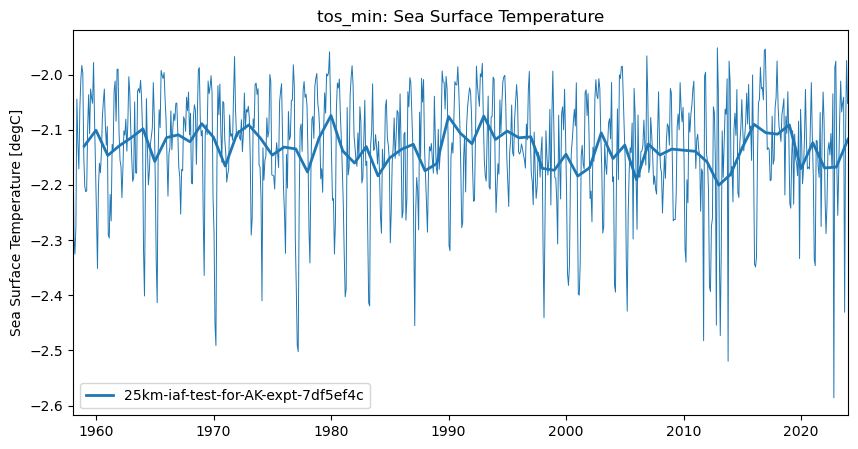

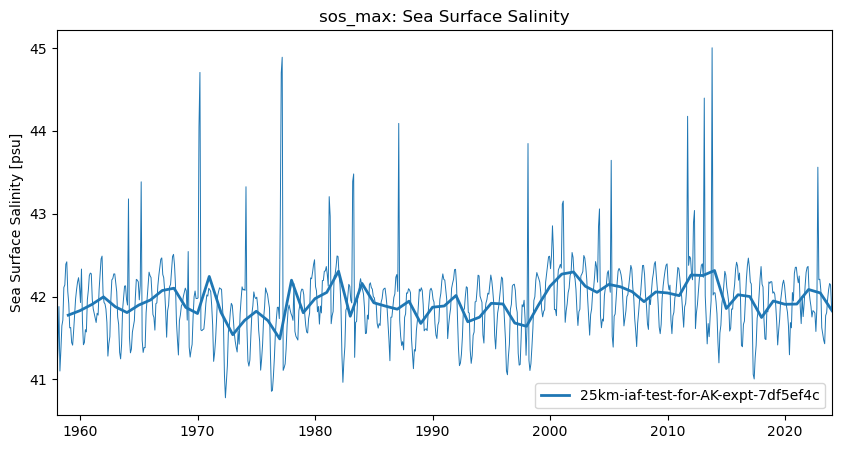

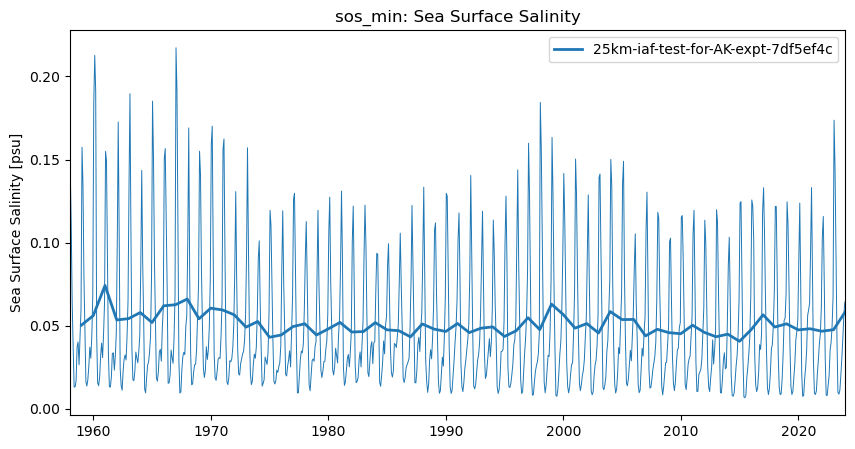

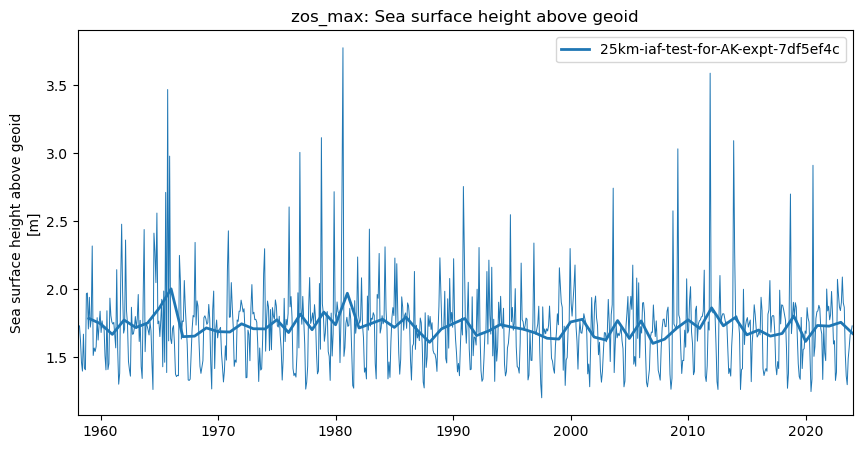

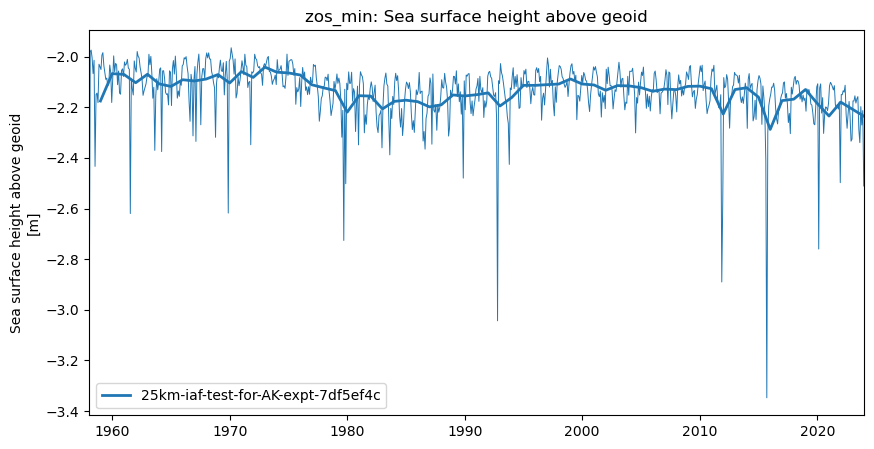

In [15]:
for k, d in data.items():
    print(k)
    fname = thisdir+k+'_'+list(d.values())[-1][k].attrs['long_name'].replace(' ', '_').replace('/','_')+'-IC.png'
    # print(fname)
    if False: #os.path.isfile(fname):
        print(f'---- skipping existing file {fname}')
    else:
        plt.figure(figsize=(10,5))
        ax = plt.subplot(111)
        for n, ds in d.items():
            dat = ds[k].sel(time=trange)
            if dat.cell_methods.find('time: mean') >= 0:
                # calculate spatial average if needed
                if 'depth' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
                    dat = grid.average(dat, ['X', 'Y', 'Z'])
                elif 'longitude' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
                    dat = grid.average(dat, ['X', 'Y'])
            elif dat.cell_methods.find('time: max') >= 0:
                dat = dat.cf.max(dim=['longitude', 'latitude'])
            elif dat.cell_methods.find('time: min') >= 0:
                dat = dat.cf.min(dim=['longitude', 'latitude'])
            # dat = dat - dat.isel(time=0)
            dat.load()
            # if int((dat.time[1]-dat.time[0]).values/1e9/60/60/24) == 1:
            #     label = 'daily'
            # else:
            #     label = 'monthly mean' # possible BUG: plausible guess
            # p = dat.plot(label=' '.join([n, label]), linewidth=1)
            p = dat.plot(linewidth=.7)
            dat.cf.resample(time='1YE').mean('time').plot(
                color=p[-1].get_color(),
                linewidth=2,
                label=n
            )
            # dat.cf.rolling(time=12, center=True).mean('time').plot()
            # dat.cf.rolling(time='1YE', center=True).mean('time').plot()
        # NB: title from first item (OM3), but y axis label from last item (may be OM2)
        # plt.title(k+': '+list(d.values())[0][k].attrs['long_name'])
        plt.title(f'{k}: {dat.attrs["long_name"]}')
        plt.xlabel('')
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.legend()
        # # Shrink current axis's height from the bottom
        # box = ax.get_position()
        # ax.set_position([box.x0, box.y0 + box.height * 0.4,
        #                  box.width, box.height * 0.6])
        # # Put a legend below current axis
        # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08))
        # # try:
        #     plt.savefig(fname, dpi=150)
        #     print(f'saved {fname}')
        # except FileNotFoundError:
        #     print(f'*** FileNotFoundError when saving {fname}')
        # break

soga
thetaoga
tosga
sosga
speed_max
mlotst_max
tos_max
tos_min
sos_max
sos_min
zos_max
zos_min


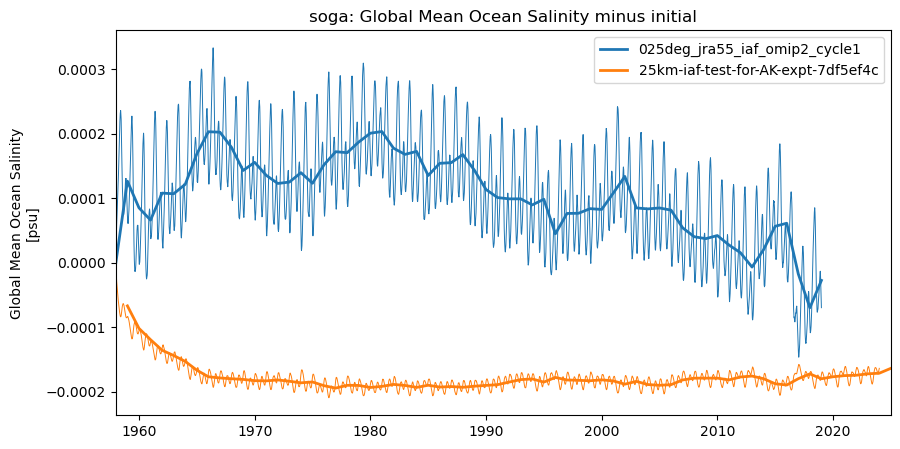

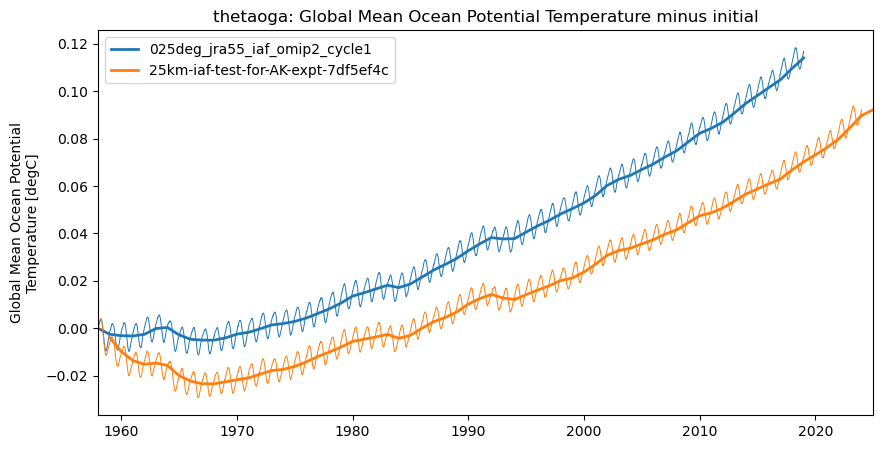

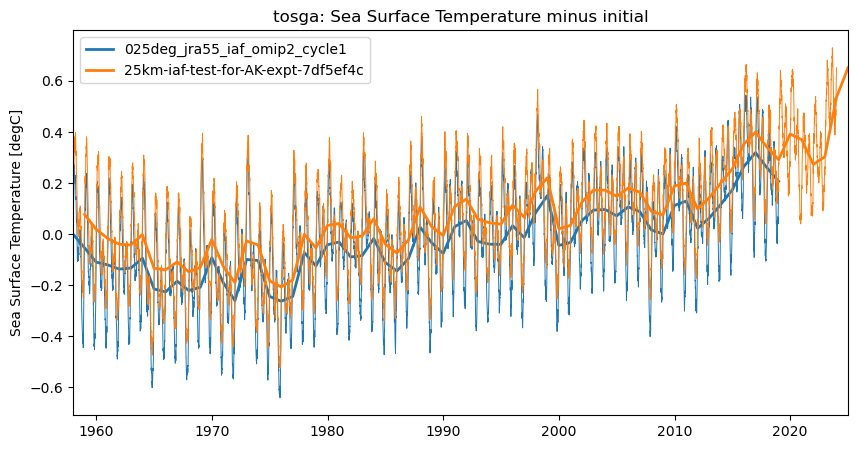

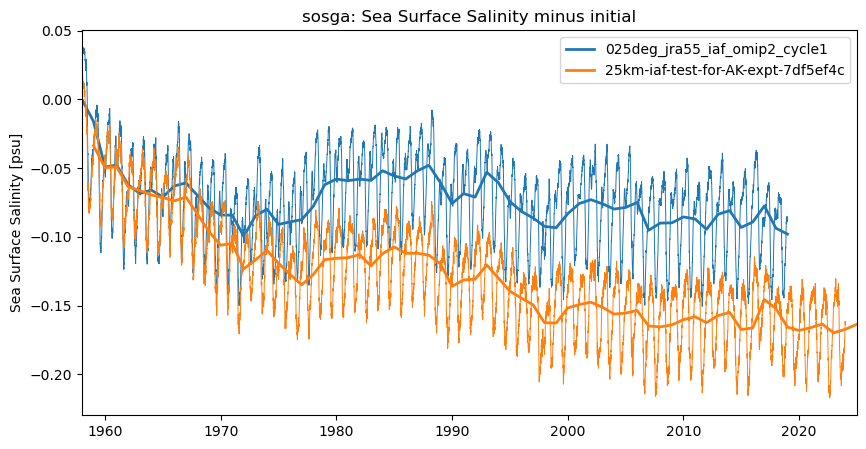

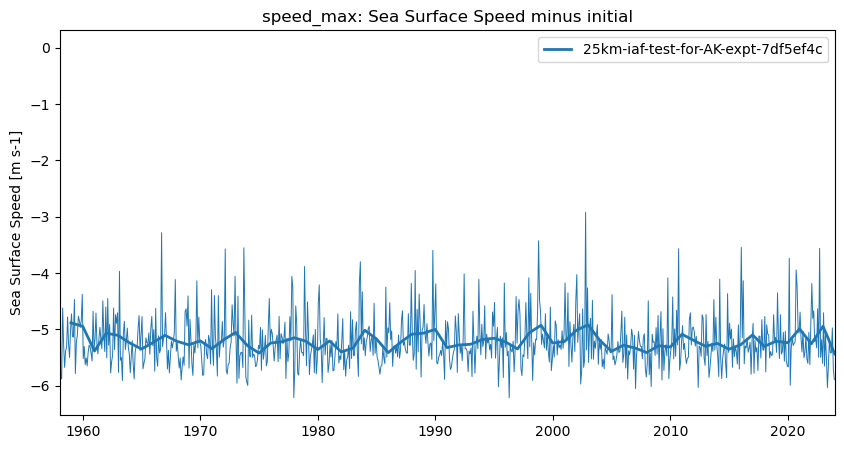

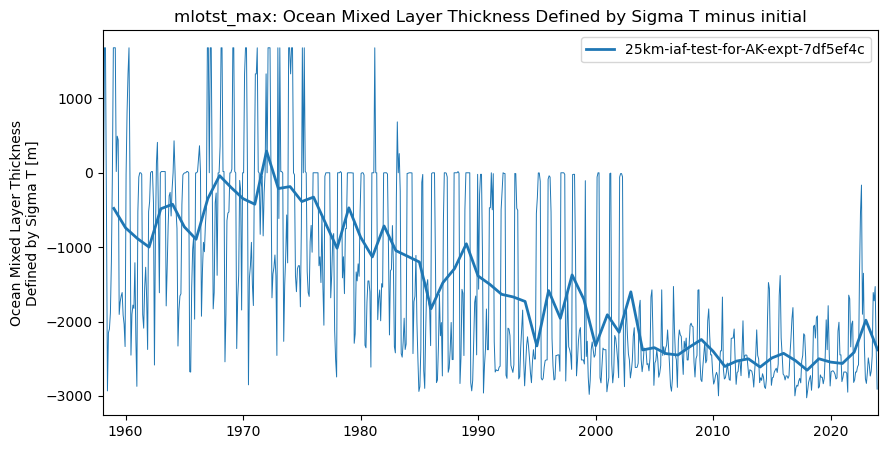

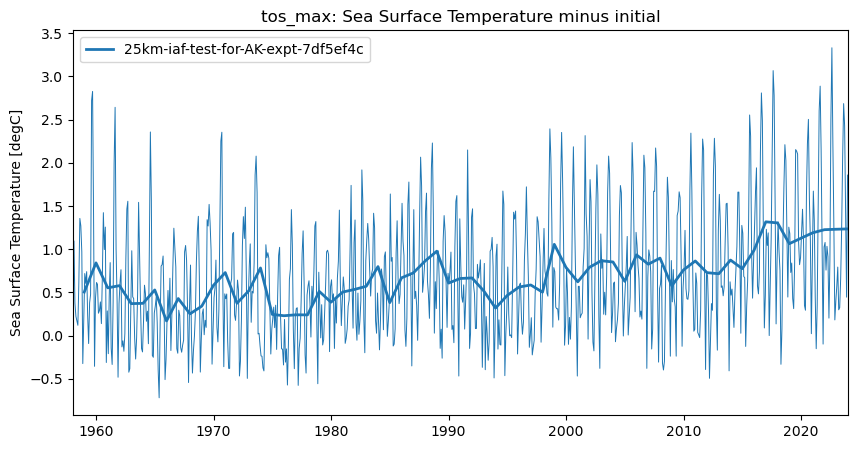

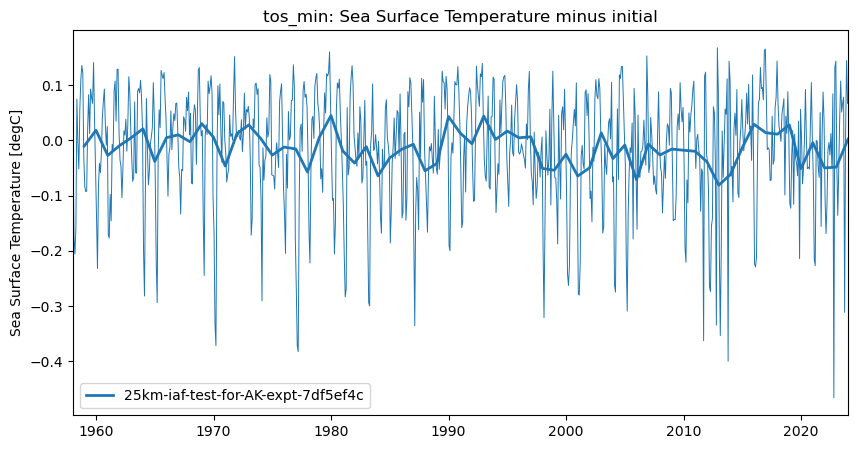

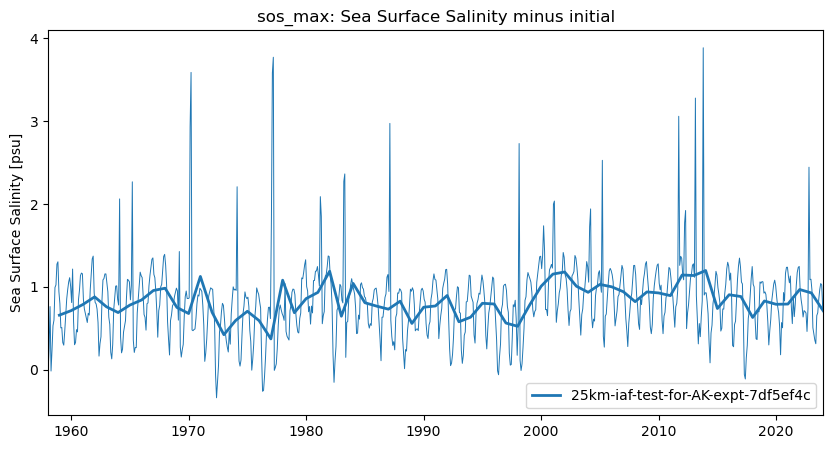

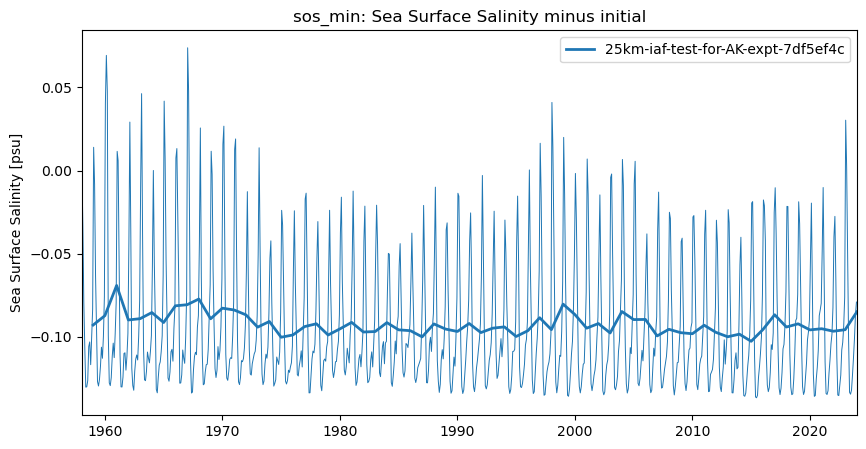

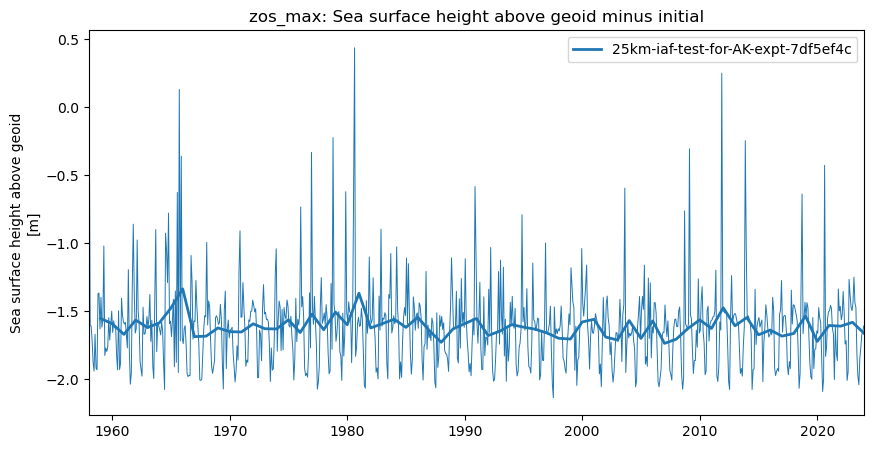

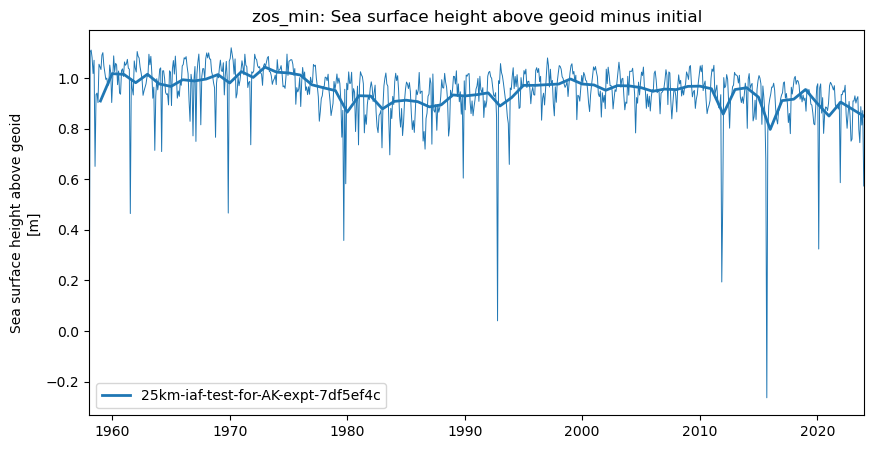

In [16]:
for k, d in data.items():
    print(k)
    fname = thisdir+k+'_'+list(d.values())[-1][k].attrs['long_name'].replace(' ', '_').replace('/','_')+'-IC.png'
    # print(fname)
    if False: #os.path.isfile(fname):
        print(f'---- skipping existing file {fname}')
    else:
        plt.figure(figsize=(10,5))
        ax = plt.subplot(111)
        for n, ds in d.items():
            dat = ds[k].sel(time=trange)
            if dat.cell_methods.find('time: mean') >= 0:
                # calculate spatial average if needed
                if 'depth' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
                    dat = grid.average(dat, ['X', 'Y', 'Z'])
                elif 'longitude' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
                    dat = grid.average(dat, ['X', 'Y'])
            elif dat.cell_methods.find('time: max') >= 0:
                dat = dat.cf.max(dim=['longitude', 'latitude'])
            elif dat.cell_methods.find('time: min') >= 0:
                dat = dat.cf.min(dim=['longitude', 'latitude'])
            dat = dat - dat.isel(time=0)
            dat.load()
            # if int((dat.time[1]-dat.time[0]).values/1e9/60/60/24) == 1:
            #     label = 'daily'
            # else:
            #     label = 'monthly mean' # possible BUG: plausible guess
            # p = dat.plot(label=' '.join([n, label]), linewidth=1)
            p = dat.plot(linewidth=.7)
            dat.cf.resample(time='1YE').mean('time').plot(
                color=p[-1].get_color(),
                linewidth=2,
                label=n
            )
            # dat.cf.rolling(time=12, center=True).mean('time').plot()
            # dat.cf.rolling(time='1YE', center=True).mean('time').plot()
        # NB: title from first item (OM3), but y axis label from last item (may be OM2)
        # plt.title(k+': '+list(d.values())[0][k].attrs['long_name'])
        plt.title(f'{k}: {dat.attrs["long_name"]} minus initial')
        plt.xlabel('')
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.legend()
        # # Shrink current axis's height from the bottom
        # box = ax.get_position()
        # ax.set_position([box.x0, box.y0 + box.height * 0.4,
        #                  box.width, box.height * 0.6])
        # # Put a legend below current axis
        # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08))
        # # try:
        #     plt.savefig(fname, dpi=150)
        #     print(f'saved {fname}')
        # except FileNotFoundError:
        #     print(f'*** FileNotFoundError when saving {fname}')
        # break